# Import Libraries

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import optimize
from datetime import date, timedelta

# Volatility & Stock Paths

The function below returns the volatility and stock paths.

In [2]:
def volatility_and_stock_paths(S0, r, kappa, theta, v0, eps, corr, n, N):

  today = date.today()
  expiry = today + timedelta(days = n)
  dates = [today + timedelta(days=i) for i in range((expiry - today).days + 1)]
  T = (expiry - today).days/365
  times = [(dates[i] - today).days/365 for i in range(n)]
  assert len(times) == n, 'Error in split'

  V = []
  S = []

  for j in range(N):
      rng = np.random.default_rng()
      mean = [0, 0]
      cov = [[1, corr], [corr, 1]]
      samples = rng.multivariate_normal(mean, cov, size=n, method='cholesky')

      v = [v0]  # list to store volatility values
      s = [S0]
      for i in range(1, n):
          delta_t = times[i] - times[i - 1]
          assert delta_t >= 0.00001, print(f'{delta_t} is negative')

          #n components of volatility path for 1 simulation
          vi = v[i - 1] + kappa * (theta - v[i - 1]) * delta_t + eps * np.sqrt(v[i - 1] * delta_t) * samples[i, 1]
          assert v[i - 1] * delta_t >= -1, print(v[i - 1] * delta_t)
          vi_max = max(vi, 0)
          v.append(vi_max)

          #n components of stock path for 1 simulation
          Si = s[i - 1]*np.exp((r - v[i - 1]/2)*delta_t + np.sqrt(v[i - 1]*delta_t)*samples[i, 0])
          Si_max = max(Si,0)
          s.append(Si_max)
      V.append(v)
      S.append(s)

  return {'volatility paths': V, 'stock paths': S}

# Visualization of Paths

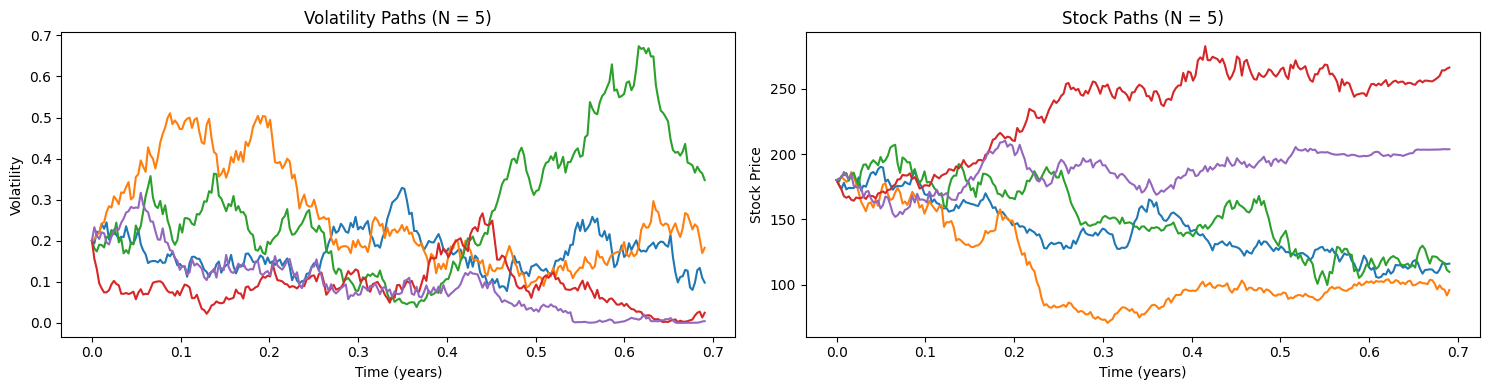

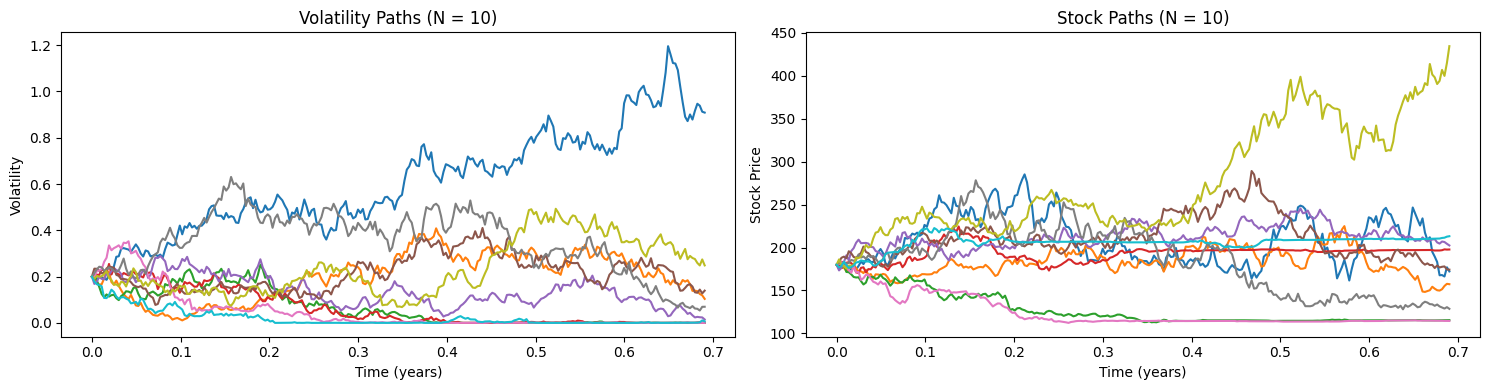

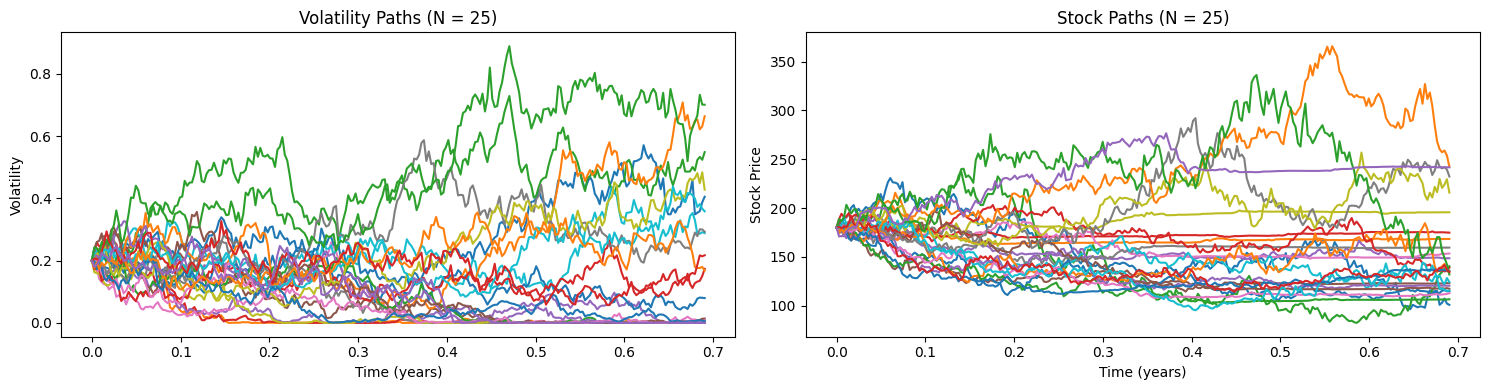

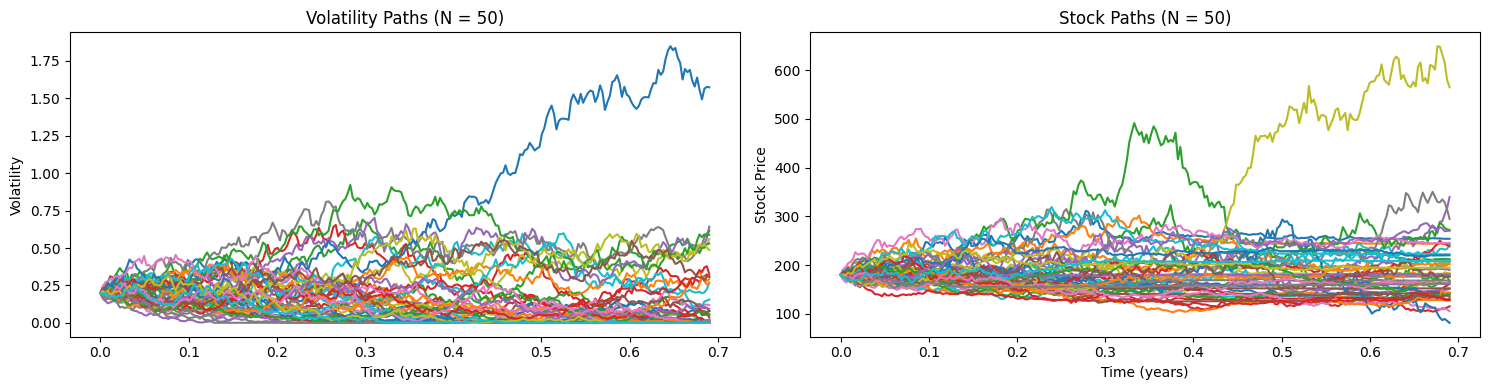

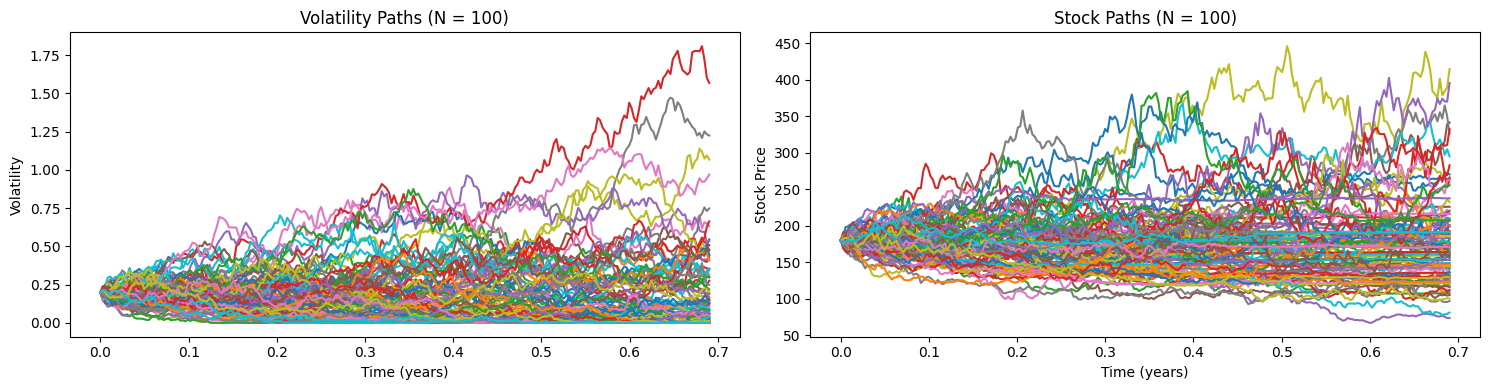

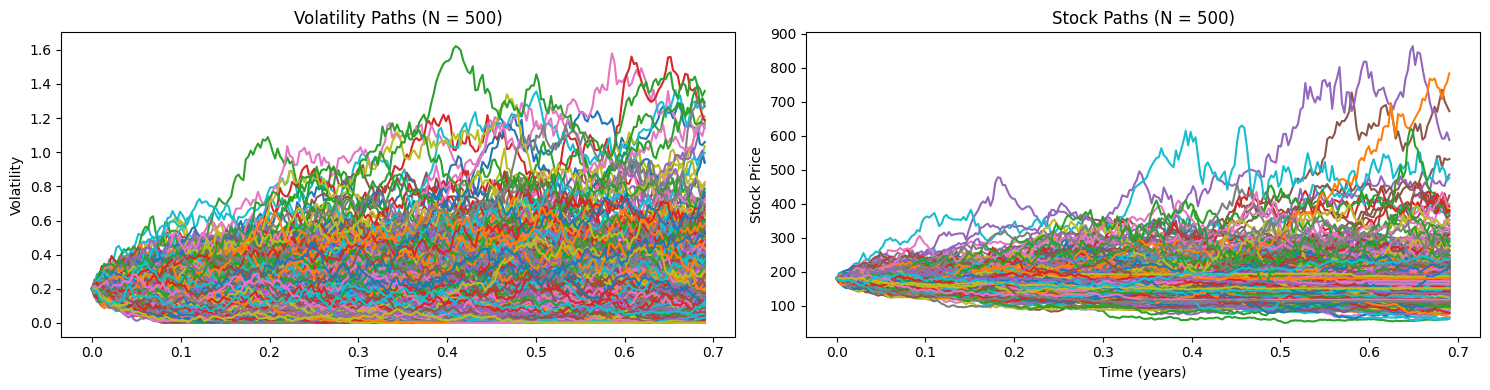

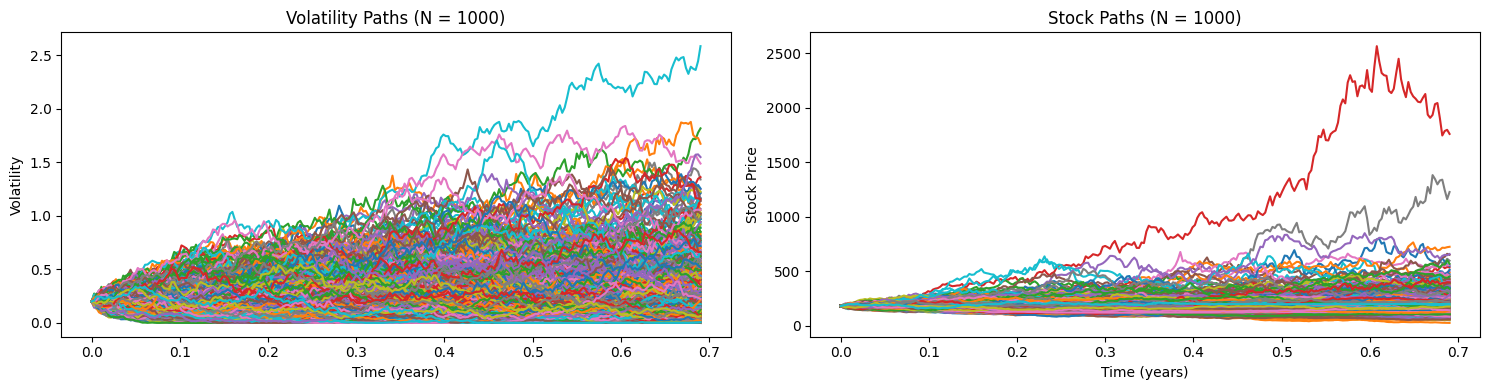

In [3]:
# Parameters
S0 = 180  # Initial stock price
r = 0.04  # Risk-free rate
kappa = 0.08  # Mean reversion speed
theta = 0.20  # Long-term volatility
v0 = 0.20  # Initial volatility
eps = 0.80  # Volatility of volatility
corr = 0.4  # Correlation between stock and volatility
n = 252  # Number of time steps (daily for 1 year)
N_values = [5, 10, 25, 50, 100, 500, 1000] #Number of simulations, will iterate through each.

for N in N_values:

    result = volatility_and_stock_paths(S0, r, kappa, theta, v0, eps, corr, n, N)
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)

    for path in result['volatility paths']:
        plt.plot(np.linspace(0, n/365, n), path)
    plt.title(f'Volatility Paths (N = {N})')
    plt.xlabel('Time (years)')
    plt.ylabel('Volatility')

    plt.subplot(1, 2, 2)
    for path in result['stock paths']:
        plt.plot(np.linspace(0, n/365, n), path)
    plt.title(f'Stock Paths (N = {N})')
    plt.xlabel('Time (years)')
    plt.ylabel('Stock Price')

    plt.tight_layout()
    plt.show()


# European Call Option - Heston Model

Pricing a European call option using the Heston model.

In [4]:
# Heston Model Params #
kappa = 0.8    # kappa: mean reversion rate for v(t)
theta = 0.20   # theta: long-run average of v(t)
v0 = 0.10      # v0: initial squared volatility
eps = 0.80     # eps: volatility of volatility
corr = -0.1    # corr: correlation between the standard GM underlying S(t) and v(t)

# Monte Carlo Params #
n = 10         #number of splits which occurs every day, i.e. number of time steps
N = 100000     # N: number of simulation paths

In [5]:
data = volatility_and_stock_paths(S0, r, kappa, theta, v0, eps, corr, n, N)

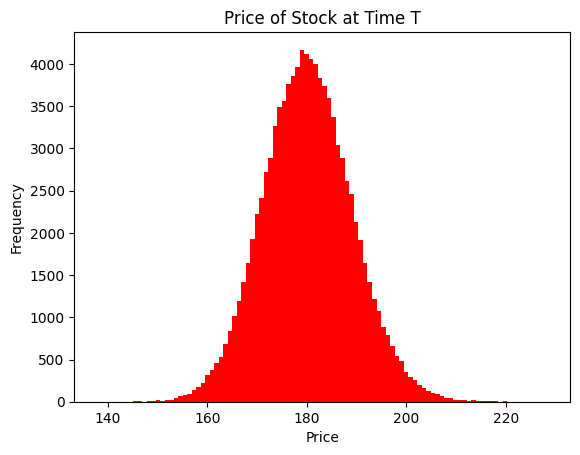

In [6]:
ST = [data['stock paths'][i][-1] for i in range(len(data['stock paths']))]
plt.hist(ST,bins=100, color='red');
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price of Stock at Time T');

In [7]:
def call_option_price_heston(S0, T, r, q, K, kappa, theta, v0, eps, corr, n, N):
  data = volatility_and_stock_paths(S0, r, kappa, theta, v0, eps, corr, n, N)
  ST = np.array([data['stock paths'][i][-1] for i in range(len(data['stock paths']))])
  disc_payoffs = np.exp(-r*T) * np.maximum(ST-K, 0.0)
  sim_price = np.mean(disc_payoffs)
  return sim_price

In [8]:
def call_option_price_heston(S0, T, r, q, K, kappa=None, theta=None, v0=None, eps=None, corr=None, n=None, N=None):

    """Ensure missing parameters have default values"""
    kappa = kappa if kappa is not None else 0.8    # Default kappa
    theta = theta if theta is not None else 0.20   # Default theta
    v0 = v0 if v0 is not None else 0.10            # Default v0
    eps = eps if eps is not None else 0.80         # Default eps
    corr = corr if corr is not None else -0.1      # Default corr
    n = n if n is not None else 10                 # Default n (number of time steps)
    N = N if N is not None else 100000             # Default N (number of simulations)

    data = volatility_and_stock_paths(S0, r, kappa, theta, v0, eps, corr, n, N)
    ST = np.array([data['stock paths'][i][-1] for i in range(len(data['stock paths']))])
    disc_payoffs = np.exp(-r*T) * np.maximum(ST - K, 0.0)
    sim_price = np.mean(disc_payoffs)
    return sim_price


In [32]:
import time
start_time = time.time()

# European call option parameters

strikes = [i for i in range(150, 215, 5)] # Strike ranges from 150, 155, ..., 210

strike_price_dict = {'Strike':[], 'Heston Model (Price)':[]}
for k in strikes:
  strike_price_dict['Heston Model (Price)'].append(call_option_price_heston(180, 1/12, 0.04, 0.015, k))
  strike_price_dict['Strike'].append(k)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.4f} seconds")


Execution time: 173.9441 seconds


In [36]:
df = pd.DataFrame(strike_price_dict)
df

,Strike,Heston Model (Price)
0,150,30.058910
1,155,25.106869
2,160,20.134485
3,165,15.299702
4,170,10.735990
5,175,6.724545
6,180,3.653777
7,185,1.693958
8,190,0.659427
9,195,0.214912


These are the prices of a single simulated option price (for different strikes K = 150, 155, ..., 210.  If we wanted to get a better estimate we would need to run many simulations and then take the expected value of this array of prices.  For example, consider the code chunk below.

In [25]:
import time
start_time = time.time()

estimate = []
sims = 5 #push towards inf depending on compuational power
for i in range(sims):
  estimate.append(call_option_price_heston(180, 1/12, 0.04, 0.015, 150))

heston_price = np.mean(np.array(estimate))


end_time = time.time()
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.4f} seconds\n")

print(f'The heston model price: ${heston_price}')

Execution time: 66.8684 seconds

The heston model price: $30.077513365202698


# Implied Volatility & Volatility Smile

Now, clearly the computational costs pose an issue.  Therefore, assume that 1 simulation is enough, and we get a 'good' estimate for the European call option.  Let us calculate the implied volatility assuming this price is the BSM price on the market.

In [26]:
def BSM_call_price(S0, T, r, q, K, v):
  d1 = (np.log(S0/K) + (r - q + v**2 /2)*T) / (v*np.sqrt(T))
  d2 = d1 - v*np.sqrt(T)
  price = S0*np.exp(-q*T)*stats.norm.cdf(d1) - K*np.exp(-r*T)*stats.norm.cdf(d2)
  return price

In [40]:
df['BSM (Price) & v0 = 10**-5'] = [BSM_call_price(180, 1/12, 0.04, 0.015, k, 10**-5) for k in strikes]
df['Heston - BSM'] = df['Heston Model (Price)'] - df['BSM (Price) & v0 = 10**-5']
df['Convergence'] = df['Heston - BSM'].apply(lambda x: True if x>=0 else False)

In [50]:
df

,Strike,Heston Model (Price),BSM (Price) & v0 = 10**-5,Heston - BSM,Convergence
0,150,30.058910,30.274308,-0.215398,False
1,155,25.106869,25.290947,-0.184078,False
2,160,20.134485,20.307586,-0.173101,False
3,165,15.299702,15.324225,-0.024523,False
4,170,10.735990,10.340864,0.395126,True
5,175,6.724545,5.357503,1.367042,True
6,180,3.653777,0.374142,3.279635,True
7,185,1.693958,0.000000,1.693958,True
8,190,0.659427,0.000000,0.659427,True
9,195,0.214912,0.000000,0.214912,True


In [110]:
def implied_volatility(S0, T, r, q, K, market_price):

    # Calculate BSM price at implied volatility of 10^-5 which is approx 0, i.e., the lowest price for these parameters.
    bsm_price = BSM_call_price(S0, T, r, q, K, 10**-5)

    # If the market price (simulated using Heston model) is less than the BSM price, return implied vol = 0
    if market_price < bsm_price:
        return 0.0  # Implied volatility should be zero in these cases to avoid failure to converge in optimization

    def objective(v):
        bsm_price = BSM_call_price(S0, T, r, q, K, v)
        return bsm_price - market_price

    return optimize.newton(objective, x0=0.3)

In [111]:
S0, T, r, q = 180, 1/12, 0.04, 0.015

market_prices = list(df['Heston Model (Price)'].values)
implied_vols = {'Strike':[], 'Implied Volatility':[]}
for k, market_price_k in zip(strikes,market_prices):
  imp_vol = implied_volatility(S0, T, r, q, k, market_price_k)
  implied_vols['Strike'].append(k)
  implied_vols['Implied Volatility'].append(imp_vol)

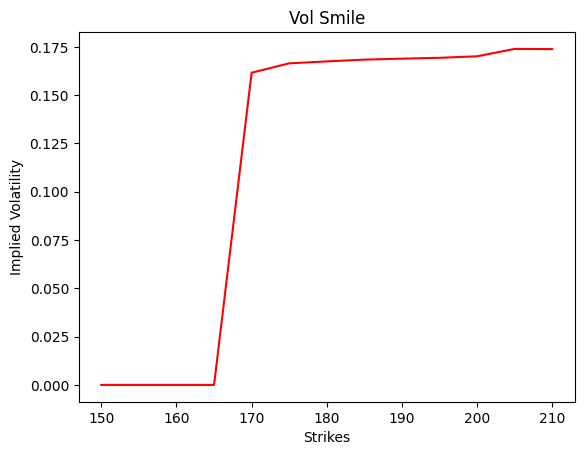

In [109]:
plt.plot(implied_vols['Strike'], implied_vols['Implied Volatility'], color = 'red')
plt.xlabel('Strikes');
plt.ylabel('Implied Volatility');
plt.title('Vol Smile');